In [15]:
#Python version
!python --version

Python 3.8.5


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MetaTrader5 as mt5

from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline 

In [17]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,          # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!


In [28]:
# extract information from pair and timeframe
Symbol = "EURUSD"
Timeframe = mt5.TIMEFRAME_D1
symbol_info = mt5.symbol_info(Symbol)
if symbol_info==None:
    print("Symbol {} not found, error code {}".format(Symbol, mt5.last_error()))

# getbars from the current day
bar = 1000
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, bar)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

# turn rates frame into csv file
rates_frame.to_csv('./Datasets/{}_{}.csv'.format(Symbol, Timeframe), index=False)
df = pd.read_csv('./Datasets/{}_{}.csv'.format(Symbol, Timeframe))


Display dataframe with data
          time     open     high      low    close  tick_volume  spread  \
0   2017-08-04  1.18746  1.18891  1.17280  1.17803      68221.0     5.0   
1   2017-08-07  1.17723  1.18137  1.17697  1.17936      45230.0     2.0   
2   2017-08-08  1.17930  1.18237  1.17150  1.17484      55823.0     5.0   
3   2017-08-09  1.17482  1.17637  1.16887  1.17549      69952.0     3.0   
4   2017-08-10  1.17547  1.17847  1.17039  1.17727      64338.0     4.0   
..         ...      ...      ...      ...      ...          ...     ...   
995 2021-06-08  1.21910  1.21951  1.21649  1.21692      46845.0     7.0   
996 2021-06-09  1.21712  1.22190  1.21712  1.21751      37724.0     7.0   
997 2021-06-10  1.21770  1.21953  1.21437  1.21731      59859.0     7.0   
998 2021-06-11  1.21732  1.21938  1.20910  1.21054      42207.0     7.0   
999 2021-06-14  1.21001  1.21102  1.20928  1.20975       5750.0     7.0   

     real_volume  
0            0.0  
1            0.0  
2            

0    1.17803
1    1.17936
2    1.17484
3    1.17549
4    1.17727
Name: close, dtype: float64

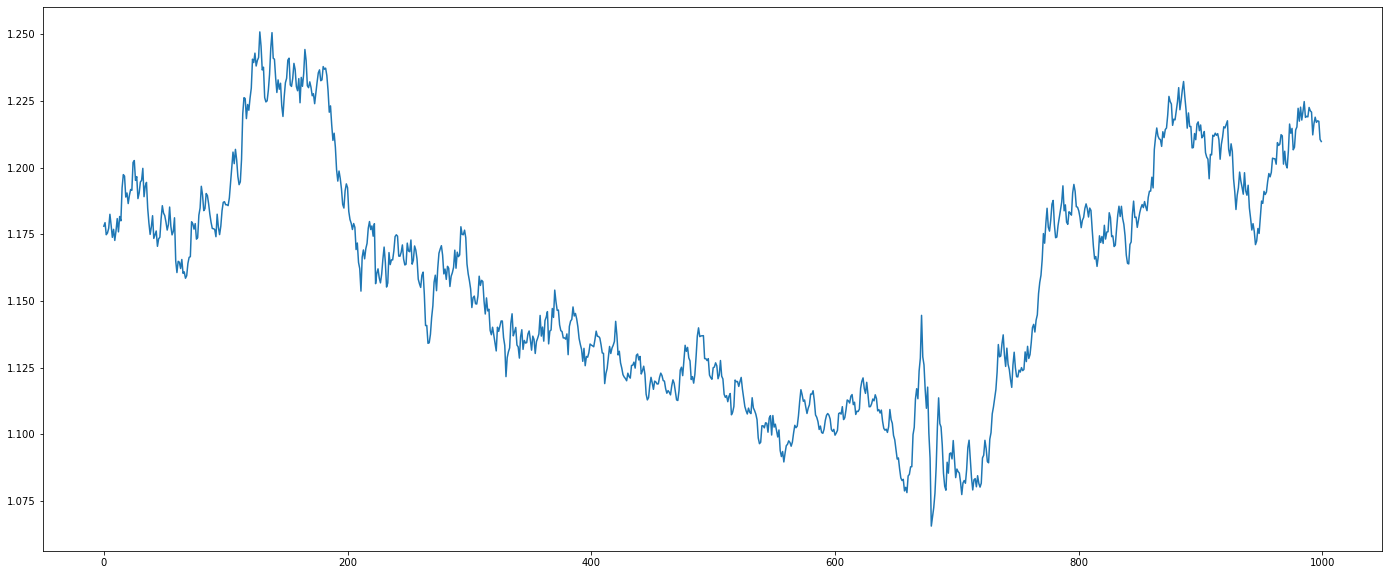

In [29]:
df = df['close']
df.fillna(0, inplace=True)
df.plot(figsize=(24,10))
df.head()

In [36]:
train = df[0:int(len(df)*0.80)]
#scale the data
scale = MinMaxScaler(feature_range=(0, 1))
scaled_df = scale.fit_transform(train)

In [33]:
def processData(df,lb):
    X,Y = [],[]
    for i in range(len(df)-lb-1):
        X.append(df[i:(i+lb),0])
        Y.append(df[(i+lb),0])
    return np.array(X),np.array(Y)

In [39]:
lb=14
train_size = 0.9
X,y = processData(scaled_df,lb)
X_train,X_test = X[:int(X.shape[0]*train_size)],X[int(X.shape[0]*train_size):]
y_train,y_test = y[:int(y.shape[0]*train_size)],y[int(y.shape[0]*train_size):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

706 14
79 14
706
79


In [42]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
 
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [45]:
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 2/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 3/100
23/23 [==============================] - 1s 32ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 4/100
23/23 [==============================] - 1s 32ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 5/100
23/23 [==============================] - 1s 34ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 6/100
23/23 [==============================] - 1s 35ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 7/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 8/100
23/23 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 9/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0010 - val_loss: 0.0013

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(24,10))
 
Xt = model.predict(X_train)
plt.plot(scale.inverse_transform(y_train.reshape(-1,1)), label="Actual Price")
plt.plot(scale.inverse_transform(Xt), label="Predicted Price")
plt.legend()
plt.title("Trained Dataset")